In [1]:
import gensim
import os
import re
import numpy as np
import json as js
import argparse
import pandas as pd
import sklearn
import joblib
import torch
import matplotlib.pyplot as plt
import datasets
import tensorflow as tf
from tqdm import tqdm
from datasets import Dataset, DatasetDict
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.naive_bayes import GaussianNB
from gensim.models import KeyedVectors
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer



2024-06-03 13:32:58.619193: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 13:32:58.823544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 13:32:59.532703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")



2024-06-03 13:33:05.123106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 13:33:05.126917: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls

In [3]:
def getDataJSON(route):
    with open(route,"r",encoding="utf-8") as f:
        result = [js.loads(jline.replace("diff","value")) for jline in f.read().splitlines()]
    return result

In [4]:
def specialTokens(text):
    text=text.replace("\n", "")
    return text

In [5]:
def tokenization(example,label):

    return tokenizer(example[label],padding=True, truncation=True, max_length=512,return_tensors="pt")

In [6]:
def utils_bert_embedding(txt, tokenizer, model):

    inputs = tokenizer(txt, return_tensors='tf', padding=True, truncation=True, max_length=512)
    outputs = model(inputs)
    vectorized_texts = outputs.last_hidden_state[:, 0, :].numpy()
    return vectorized_texts


In [7]:
def row_to_vector(row):
    return row.values

In [8]:
def dataToCsv(datadir):
    aux = os.path.join(datadir, "train.jsonl")
    data = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data[['text1','text2']] = pd.DataFrame(data.pair.tolist(), index= data.index)

    aux = os.path.join(datadir, "train_truth.jsonl")

    del data["pair"]
    data2 = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data = pd.merge(data,data2,how='outer',left_index=True,right_index=True)
    del data2

    X_0 = data["text1"]
    X_1 = data["text2"]
    X = X_0 + "[SEP]" + X_1
    X = X.apply(specialTokens)

    Y = data["value"].to_frame()

    X_series = pd.concat([X, Y], axis=1)
    X_series.to_csv(datadir + "prepared.csv")
    return X_series
    
    


In [33]:
dataToCsv("../corpus/dataset1/train/prepared/")

,0,value
id,,
1-1-2,"[CLS] I'm not arguing with you here, I'm simpl...",1
1-2-3,[CLS] He's at my place half the time and his f...,0
10-1-2,[CLS] Biden has the power to write an executiv...,1
10-2-3,[CLS] r/politics is currently accepting new mo...,1
10-3-4,[CLS] The inflation reduction act increases in...,0
...,...,...
997-3-4,[CLS] He’s 89. His term is six years. SIX YEAR...,1
998-1-2,[CLS] Kanye is being manipulated and taken adv...,1
998-2-3,[CLS] IDK. Jessie's story was all about him ge...,1


In [34]:
dataToCsv("../corpus/dataset1/validation/prepared/")

,0,value
id,,
1-1-2,[CLS] I think the premise of your question is ...,1
10-1-2,[CLS] You bought this in good faith and withou...,1
10-2-3,[CLS] Yes. That section of the code says what ...,1
100-1-2,"[CLS] She doesnt “savage” anyone, no one is “f...",1
100-2-3,[CLS] I left Ohio in 1998. Never looked back. ...,1
...,...,...
97-4-5,[CLS] r/politics is currently accepting new mo...,1
98-1-2,"[CLS] Trump committed many crimes, LIVE ON TEL...",1
98-2-3,[CLS] No shit. Not all investigations take the...,1


In [23]:
data[0][0]

/tmp/ipykernel_114607/154174995.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[0][0]


"[CLS] I'm not arguing with you here, I'm simply trying to contextualize this for you. To the extent that they are there, it is with your consent. The state has passed laws making sure that vulnerable people (not saying he's one) don't get abused (not saying you're abusing him), and in casting a wide net to save as many vulnerable little birds as possible from hitting the floor after being kicked out of their nest wrongfully, the state has (as much from a lack of better options as from any other reason) created a circumstance where occasionally some not-so-vulnerable little bird can take advantage of someone else's nest.[SEP]He's at my place half the time and his fiance(e)'s place the other half of the time. He's been (homeless) couch surfing for several years and only recently got engaged to his other partner. We don't have any current issues that would lead me to want this arrangement to stop, but I do want to protect my own legal rights. [SEP]"

In [9]:

def BERTProcessing(datadir,tokenizer,model):
    aux = os.path.join(datadir, "train.jsonl")
    data = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data[['text1','text2']] = pd.DataFrame(data.pair.tolist(), index= data.index)

    aux = os.path.join(datadir, "train_truth.jsonl")

    del data["pair"]
    data2 = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data = pd.merge(data,data2,how='outer',left_index=True,right_index=True)
    del data2

    
    X_0 = data["text1"]
    X_0 = X_0.apply(specialTokens)
    X_0_frame=X_0.to_frame()
    lst_mean_vecs_X_0 = [(utils_bert_embedding(txt,tokenizer, model)[0]) for txt in tqdm(X_0_frame["text1"])]

    X_1 = data["text2"]
    X_1 = X_1.apply(specialTokens)
    X_1_frame=X_1.to_frame()
    lst_mean_vecs_X_1 = [(utils_bert_embedding(txt,tokenizer, model)[0]) for txt in tqdm(X_1_frame["text2"])]

    list_X_0 = np.array(lst_mean_vecs_X_0)
    list_X_1 = np.array(lst_mean_vecs_X_1)

    Y = data["value"].to_frame()

    X_df0=pd.DataFrame(list_X_0,index=data.index).apply(row_to_vector,axis=1)
    X_df1=pd.DataFrame(list_X_1,index=data.index).apply(row_to_vector,axis=1)
    
    
 
    Y = data["value"]
    print("$$$$$$-DONE-$$$$$$")
    return X_df0,X_df1,Y



In [10]:

def BERTProcessingOneText(datadir,tokenizer,model):
    aux = os.path.join(datadir, "train.jsonl")
    data = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data[['text1','text2']] = pd.DataFrame(data.pair.tolist(), index= data.index)

    aux = os.path.join(datadir, "train_truth.jsonl")

    del data["pair"]
    data2 = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data = pd.merge(data,data2,how='outer',left_index=True,right_index=True)
    del data2

    
    X_0 = data["text1"] + " [SEP] " + data["text2"]
    X_0 = X_0.apply(specialTokens)
    X_0_frame=X_0.to_frame()
    lst_mean_vecs_X_0 = [(utils_bert_embedding(txt,tokenizer, model)[0]) for txt in tqdm(X_0_frame[0])]

    
    list_X_0 = np.array(lst_mean_vecs_X_0)

    Y = data["value"].to_frame()

    X_df0=pd.DataFrame(list_X_0,index=data.index).apply(row_to_vector,axis=1)
    
    
 
    Y = data["value"]
    X = pd.concat([X_df0, Y], axis=1)
    print("$$$$$$-DONE-$$$$$$")
    return X



In [8]:
def comparation(X1, X2):
    result=X1 - X2
    return result

In [58]:
data=BERTProcessingOneText("../corpus/dummyset/train/prepared/",tokenizer,model)
data

100%|██████████| 247/247 [00:46<00:00,  5.27it/s]

$$$$$$-DONE-$$$$$$


,0,value
id,,
1-1-2,"[0.23213123, -0.01940576, -0.4982503, -0.20774...",1
1-2-3,"[0.12999731, 0.0013807118, -0.21989939, -0.219...",0
10-1-2,"[0.12304676, -0.1575891, -0.1262363, -0.083044...",1
10-2-3,"[0.09427981, -0.17273273, -0.14094776, 0.14100...",1
10-3-4,"[0.008588837, -0.17707774, -0.27153295, -0.055...",0
...,...,...
84-4-5,"[0.25262803, -0.17730996, 0.4167732, 0.3965798...",1
84-5-6,"[0.3348052, -0.060188506, 0.14304735, -0.12144...",1
9-1-2,"[-0.4034878, -0.035273504, -0.24560848, 0.2755...",1


In [54]:
data[0][0]

/tmp/ipykernel_114607/154174995.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[0][0]


"[CLS] I'm not arguing with you here, I'm simply trying to contextualize this for you. To the extent that they are there, it is with your consent. The state has passed laws making sure that vulnerable people (not saying he's one) don't get abused (not saying you're abusing him), and in casting a wide net to save as many vulnerable little birds as possible from hitting the floor after being kicked out of their nest wrongfully, the state has (as much from a lack of better options as from any other reason) created a circumstance where occasionally some not-so-vulnerable little bird can take advantage of someone else's nest. [SEP] He's at my place half the time and his fiance(e)'s place the other half of the time. He's been (homeless) couch surfing for several years and only recently got engaged to his other partner. We don't have any current issues that would lead me to want this arrangement to stop, but I do want to protect my own legal rights. [SEP]"

In [47]:
data[1]

id
1-1-2     [0.20820494, 0.008118348, -0.29047334, -0.2789...
1-2-3     [0.15894093, 0.21661529, -0.055385336, -0.2901...
10-1-2    [0.20150635, -0.21612741, -0.075830966, -0.070...
10-2-3    [-0.12223665, -0.13796741, -0.374795, 0.399254...
10-3-4    [0.20417106, -0.18636155, -0.20691139, -0.2441...
                                ...                        
84-4-5    [0.1602426, -0.2545905, 0.1615929, 0.11387552,...
84-5-6    [0.28968045, 0.041305467, -0.14422685, -0.1524...
9-1-2     [-0.17890301, 0.06874495, -0.26106945, 0.27061...
9-2-3     [-0.09804095, 0.6613869, 0.012525171, -0.14130...
9-3-4     [-0.045102734, -0.081216305, 0.07017073, -0.14...
Length: 247, dtype: object

In [59]:
data=BERTProcessingOneText("../corpus/dataset1/train/prepared/",tokenizer,model)
data
def save_series_to_jsonl(series, filename):
    series.to_json(filename, orient='records', lines=True)

def load_series_from_jsonl(filename):
    return pd.read_json(filename, lines=True)


save_series_to_jsonl(data, '../corpus/dataset1/train/processed/dataset1_OneText.jsonl')

###########################

data=BERTProcessingOneText("../corpus/dataset2/train/prepared/",tokenizer,model)
data


save_series_to_jsonl(data, '../corpus/dataset1/train/processed/dataset2_OneText.jsonl')
###########################

data=BERTProcessingOneText("../corpus/dataset3/train/prepared/",tokenizer,model)
data

save_series_to_jsonl(data, '../corpus/dataset1/train/processed/dataset3_OneText.jsonl')



100%|██████████| 12904/12904 [42:23<00:00,  5.07it/s]


$$$$$$-DONE-$$$$$$


100%|██████████| 28216/28216 [1:28:43<00:00,  5.30it/s]


$$$$$$-DONE-$$$$$$


100%|██████████| 19113/19113 [57:49<00:00,  5.51it/s] 


$$$$$$-DONE-$$$$$$


In [11]:
def load_series_from_jsonl(filename):
    return pd.read_json(filename, lines=True)

In [12]:
# Cargar la serie desde el archivo .jsonl
X = load_series_from_jsonl('../corpus/dataset1/train/processed/dataset1_OneText.jsonl')
X

/tmp/ipykernel_336767/3734992399.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(filename, lines=True)
/tmp/ipykernel_336767/3734992399.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(filename, lines=True)
/tmp/ipykernel_336767/3734992399.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'un

,0,value
0,"[0.23213122790000001, -0.0194057599, -0.498250...",1
1,"[0.129997313, 0.0013807118, -0.219899386200000...",0
2,"[0.1230467632, -0.1575890929, -0.1262363046000...",1
3,"[0.0942798108, -0.1727327257, -0.1409477592, 0...",1
4,"[0.0085888375, -0.17707774040000002, -0.271532...",0
...,...,...
12899,"[0.3295432627, 0.5966648459, 0.2758518457, -0....",1
12900,"[-0.15737254920000002, -0.3189372122, 0.062515...",1
12901,"[0.0998439789, -0.2037054151, 0.0090216771, -0...",1
12902,"[-0.0644751266, -0.0862417966, 0.3705866039000...",1


In [17]:
X["value"]

0        1
1        0
2        1
3        1
4        0
        ..
12899    1
12900    1
12901    1
12902    1
12903    1
Name: value, Length: 12904, dtype: int64

In [12]:
def cosine_sim(X1,X2):
    cos=np.dot(X1, X2) / (np.linalg.norm(X1) * np.linalg.norm(X2))
    return cos

In [30]:
Cosine = pd.Series(X.apply(lambda x: cosine_sim(x[0], x[1]), axis=1))

In [31]:
type(Cosine)

pandas.core.series.Series

In [28]:
type(data[2])

pandas.core.series.Series

In [14]:

def plot_points_with_labels(vectors_df, labels_df,titulo):
  # Asegúrate de que las etiquetas y los vectores tengan el mismo índice
  # Separa los vectores según las etiquetas
    vectors_label_0 = vectors_df[labels_df == 0]
    vectors_label_1 = vectors_df[labels_df == 1]
    
  # Crea un gráfico de puntos
    plt.figure(figsize=(8, 6))
    plt.scatter(vectors_label_1.iloc[:, 0], vectors_label_1.iloc[:, 1], color='red', label='Con cambio')
    plt.scatter(vectors_label_0.iloc[:, 0], vectors_label_0.iloc[:, 1], color='blue', label='Sin cambio')
    
    
  # Configura las etiquetas y el título
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(titulo)
   
  # Muestra la leyenda
    plt.legend()
   
  # Muestra el gráfico
    plt.show()

In [15]:
def redimensionarPCA(X):
    pca = PCA(n_components=2)
    X_vectores = X.apply(pd.Series)
    pca.fit(X_vectores.T)
    X_PCAvec = pd.DataFrame(pca.components_.T,index=X_vectores.index)
    return X_PCAvec


In [23]:
plot_points_with_labels(Cosine,data[2],"Cosine Sim")

IndexError: single positional indexer is out-of-bounds

<Figure size 800x600 with 0 Axes>

/home/gianni/Documentos/DamianW2V/Transformers/env1/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/gianni/Documentos/DamianW2V/Transformers/env1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


               0          1
0     -10.017430  12.200328
1      -9.722921  11.166442
2      -6.559274   0.541099
3      -3.815936  -4.034639
4       2.333517  -4.619865
...          ...        ...
12899  -4.917224  -6.820125
12900  -4.871961  -2.186816
12901  -5.901116  -0.318564
12902 -12.669922  14.244285
12903 -19.034169   8.494370

[12904 rows x 2 columns]


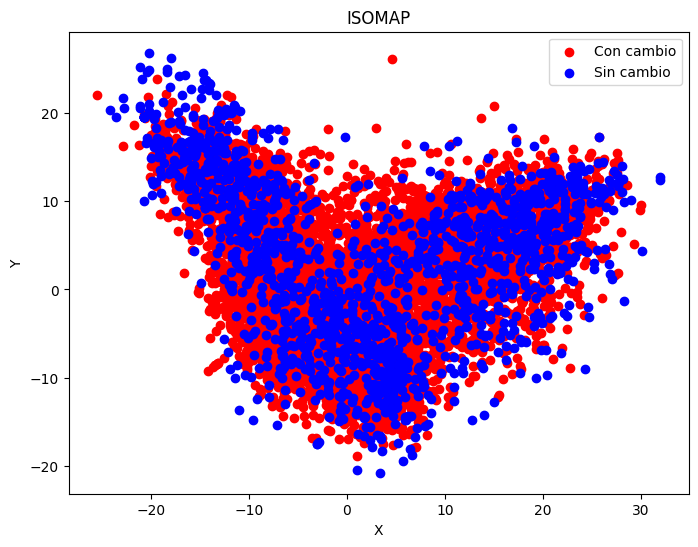

In [22]:
X_1=redimensionarISOMAP(X["0"])
plot_points_with_labels(X_1,X["value"],"ISOMAP")

In [19]:
def redimensionarTSNE(X):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
    X_vectores = X.apply(pd.Series)
    X_vec = tsne.fit_transform(X_vectores)
    X_TSNEvec = pd.DataFrame(X_vec,index=X_vectores.index)
    print(X_TSNEvec)
    return X_TSNEvec

In [21]:
def redimensionarISOMAP(X):
    isomap=Isomap(n_components=2)
    X_vectores = X.apply(pd.Series)
    X_vec = isomap.fit_transform(X_vectores)
    X_ISOMAPvec = pd.DataFrame(X_vec,index=X_vectores.index)
    print(X_ISOMAPvec)
    return X_ISOMAPvec

In [23]:
def SVM(X,Y,exitmodel):
  print('%%%%%%TRAINING MODEL%%%%%%')
  X_train=np.array(X.tolist())
  Y_train=np.array(Y.tolist())
  svm_model = SVC(kernel='rbf')
  svm_model.fit(X_train, Y_train)
  joblib.dump(svm_model,exitmodel)

In [39]:
def SVM_linear(X,Y,exitmodel):
  print('%%%%%%TRAINING MODEL%%%%%%')
  X_train=np.array(X.tolist())
  X_train=X_train.reshape(-1, 1)
  Y_train=np.array(Y.tolist())
  svm_model = SVC(kernel='linear')
  svm_model.fit(X_train, Y_train)
  joblib.dump(svm_model,exitmodel)

In [68]:
def NaiveBayes(X,Y,exitmodel):
  print('%%%%%%TRAINING MODEL%%%%%%')
  X_train=np.array(X.tolist())
  Y_train=np.array(Y.tolist())
  Bayes_model = GaussianNB()
  Bayes_model.fit(X_train, Y_train)
  joblib.dump(Bayes_model,exitmodel)

In [12]:
def RNA(X,Y,exitmodel):
  print('%%%%%%TRAINING MODEL%%%%%%')
  X_train=np.array(X.tolist())
  Y_train=np.array(Y.tolist())
  modelRNA = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(768,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  modelRNA.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
  modelRNA.fit(X_train,Y_train, epochs=10, batch_size=32)
  return modelRNA
  #joblib.dump(modelRNA,exitmodel)



In [24]:
modelRNA = SVM(X["0"],X["value"],"./model/dataset1/SVM_model.pkl")

%%%%%%TRAINING MODEL%%%%%%


In [14]:
def load_model(model_path):
  model = joblib.load(model_path)
  return model

In [15]:
def prepare_test_data(datavalidationdirectory):
  data_parsed = []

  for element in [x for x in os.listdir(datavalidationdirectory) if '.txt' in x]:
    id = re.findall(r'^[a-zA-Z\-0-9]*\-([0-9]+).txt$',element)[0]
    with open(os.path.join(datavalidationdirectory,f'problem-{id}.txt'),'r', encoding="utf-8") as f:
      data = f.readlines()

  
    comb = []
    for i in range(0,len(data)-1):
      comb.append({"id":f'{id}-{i+1}-{i+2}',"pair": [data[i],data[i+1]]})
    data_parsed.append(comb)

  with open(os.path.join(datavalidationdirectory,'validation.json'),'w',encoding="utf-8") as f:
    js.dump(data_parsed, f, indent=4)

  print("validation data prepared")


In [16]:
def evaluate_model(datavalidation_path,prediction_path,modelSVM):

  with open(os.path.join(datavalidation_path,'validation.json')) as f:
    data = js.load(f)
  print("----------- PREDICTION ------------")
  for dict in data:
    conf = []
    for dict_line in dict:
      X_0 = np.array(utils_bert_embedding(specialTokens(dict_line["pair"][0]),tokenizer, model)[0] )
      X_1 = np.array(utils_bert_embedding(specialTokens(dict_line["pair"][1]),tokenizer, model)[0] )
      X = X_0 - X_1
      #X = np.absolute(X)
      X = X.reshape(1,-1)
      temp = np.round(modelSVM.predict(X))
      print(temp)
      conf.append(int(temp))
      temp=[]

      problem_number = int(re.findall(r'([0-9]+)-[0-9]+-[0-9]+',dict_line["id"])[0])
      print(os.path.join(prediction_path,f"solution-problem-{problem_number}.json"))
      with open(os.path.join(prediction_path,f"solution-problem-{problem_number}.json"),"w+") as f:
        js.dump({"changes":conf},f)

In [27]:
def evaluate_modelOneText(datavalidation_path,prediction_path,modelSVM):

  with open(os.path.join(datavalidation_path,'validation.json')) as f:
    data = js.load(f)
  print("----------- PREDICTION ------------")
  for dict in data:
    conf = []
    for dict_line in dict:
      X = np.array(utils_bert_embedding(specialTokens(dict_line["pair"][0] + " [SEP] " + dict_line["pair"][1]),tokenizer, model)[0] )
      #X = np.absolute(X)
      X = X.reshape(1,-1)
      temp = np.round(modelSVM.predict(X))
      print(temp)
      conf.append(int(temp))
      temp=[]

      problem_number = int(re.findall(r'([0-9]+)-[0-9]+-[0-9]+',dict_line["id"])[0])
      print(os.path.join(prediction_path,f"solution-problem-{problem_number}.json"))
      with open(os.path.join(prediction_path,f"solution-problem-{problem_number}.json"),"w+") as f:
        js.dump({"changes":conf},f)

In [43]:
modelo=("./model/dataset1/CosineSim_model_linear.pkl")

In [49]:
prepare_test_data("../corpus/dataset3/validation/")

validation data prepared


In [28]:
evaluate_modelOneText("../corpus/dataset1/validation/","../corpus/dataset1/predictionsBERT/",modelRNA)

----------- PREDICTION ------------


UnboundLocalError: local variable 'X' referenced before assignment